<a href="https://colab.research.google.com/github/hyulianton/JaringanSyarafTiruan/blob/main/jst_Variational_Autoencoder_(VAE)_untuk_Generasi_Data_Baru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder (VAE) untuk Generasi Data Baru

Variational Autoencoder (VAE) adalah jenis model generatif yang dapat belajar merepresentasikan data dalam ruang dimensi yang lebih rendah (disebut *ruang laten*). Berbeda dengan Autoencoder tradisional, VAE memastikan ruang laten terstruktur dengan baik sehingga kita dapat mengambil sampel dari ruang tersebut untuk menghasilkan data baru yang realistis.

## 1. Persiapan dan Impor Pustaka

Langkah pertama adalah mengimpor semua pustaka yang diperlukan: TensorFlow/Keras untuk membangun model, NumPy untuk operasi array, dan Matplotlib untuk visualisasi.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## 2. Pengaturan Parameter dan Hyperparameter

Kita definisikan beberapa variabel kunci yang akan digunakan di seluruh program.

In [2]:
# Dimensi input gambar Fashion MNIST
IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_CHANNELS = 1
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

# Dimensi ruang laten (z). Dipilih 2 agar mudah divisualisasikan.
LATENT_DIM = 2

# Hyperparameter training
BATCH_SIZE = 128
EPOCHS = 50

## 3. Unduh dan Muat Dataset Fashion MNIST

Dataset Fashion MNIST berisi 70.000 gambar skala abu-abu (28x28 piksel) dari 10 kategori pakaian.

In [3]:
# Mendownload dan memuat data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Preprocessing Data:
# 1. Normalisasi: Ubah ke float dan bagi 255 (rentang 0-1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 2. Reshape: Tambahkan dimensi channel (28, 28) -> (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(f"Shape data training: {x_train.shape}")
print(f"Shape data testing: {x_test.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape data training: (60000, 28, 28, 1)
Shape data testing: (10000, 28, 28, 1)


## 4. Mendefinisikan Model VAE

VAE terdiri dari tiga bagian utama: Encoder, Sampling Layer (Lapisan Sampling), dan Decoder.

### 4.1. Lapisan Sampling (Reparameterization Trick)

Bagian terpenting dari VAE. Untuk memungkinkan *backpropagation* melalui proses sampling acak, kita menggunakan *Reparameterization Trick*:
$$z = \mu + \epsilon \cdot \sigma$$
dimana $\mu$ (mean) dan $\log(\sigma^2)$ (log variance) adalah output dari Encoder, dan $\epsilon$ adalah sampel dari distribusi normal standar $\mathcal{N}(0, I)$.

In [4]:
class Sampling(layers.Layer):
    """Menggunakan trik reparameterisasi untuk mengambil sampel dari z."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]

        # Sampling epsilon (noise) dari distribusi normal standar
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        # z = mu + exp(0.5 * log_var) * epsilon
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### 4.2. Encoder (Penyandi)

Encoder mengambil gambar input dan memampatkannya menjadi dua vektor: $z\_mean$ ($\mu$) dan $z\_log\_var$ ($\log \sigma^2$).

In [5]:
# 1. ENCODER
encoder_inputs = keras.Input(shape=INPUT_SHAPE)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

# Output Encoder adalah mean (mu) dan log-variance (log_sigma^2)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)

# Gunakan Custom Sampling Layer
z = Sampling()([z_mean, z_log_var])

# Definisikan model Encoder
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     50,192 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

### 4.3. Decoder (Pendekode)

Decoder mengambil sampel dari ruang laten ($z$) dan mengembalikannya ke bentuk gambar.

In [6]:
# 2. DECODER
# Input untuk decoder adalah sampel z dari ruang laten
latent_inputs = keras.Input(shape=(LATENT_DIM,))

# Mulai dengan Dense layer, lalu reshape ke ukuran kecil (7x7x64)
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)

# Gunakan Conv2DTranspose (kebalikan dari Conv2D) untuk memperbesar gambar
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)

# Output final harus memiliki 1 channel (grayscale) dan nilai antara 0-1 (sigmoid)
decoder_outputs = layers.Conv2DTranspose(
    IMG_CHANNELS, 3, activation="sigmoid", padding="same"
)(x)

# Definisikan model Decoder
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

### 4.4. Model VAE (Menggabungkan)

Kita mendefinisikan *custom* `Model` Keras untuk VAE agar bisa menyertakan *Loss Function* VAE dalam proses training.

**Loss Function VAE** terdiri dari dua bagian:
1.  **Reconstruction Loss** (Kerugian Rekonstruksi): Seberapa baik gambar yang direkonstruksi mendekati gambar asli. (Kita gunakan Binary Cross-Entropy/BCE karena outputnya dinormalisasi 0-1).
2.  **KL Divergence Loss** (Kerugian Divergensi KL): Mengukur seberapa dekat distribusi yang dipelajari Encoder $q(z|x)$ dengan distribusi prior $\mathcal{N}(0, I)$. Ini memaksa ruang laten menjadi terstruktur.

$$L_{\text{KL}} = -0.5 \sum_{i=1}^{D} (1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2)$$

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Encoder
            z_mean, z_log_var, z = self.encoder(data)
            # Decoder
            reconstruction = self.decoder(z)

            # 1. Reconstruction Loss (Binary Cross Entropy)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )

            # 2. KL Divergence Loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # Total Loss = Reconstruction Loss + KL Loss
            total_loss = reconstruction_loss + kl_loss

        # Hitung dan terapkan gradient
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## 5. Pelatihan Model (Training)

Inisialisasi VAE dan mulai pelatihan.

In [8]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

print("Memulai pelatihan VAE...")
vae.fit(x_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
print("Pelatihan selesai.")

Memulai pelatihan VAE...
Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - kl_loss: 3.4652 - loss: 401.0582 - reconstruction_loss: 397.5929
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 6.0594 - loss: 322.7852 - reconstruction_loss: 316.7258
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 5.4192 - loss: 310.7802 - reconstruction_loss: 305.3609
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 5.0466 - loss: 305.8227 - reconstruction_loss: 300.7761
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 4.8720 - loss: 302.2616 - reconstruction_loss: 297.3896
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 4.7683 - loss: 301.2798 - reconstruction_loss: 296.5114
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 4.7183 - loss: 298.7722 - reconstruction_loss: 294.0542
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 4.6732 - loss: 297.8992 - reconstruction_loss: 293.2261
Epoch 9/50
469/469 ━━

## 6. Analisis dan Visualisasi

Setelah pelatihan, kita akan menganalisis kinerja model, terutama dalam rekonstruksi dan struktur ruang laten.

### 6.1. Pengujian Rekonstruksi Gambar

Model yang baik seharusnya dapat merekonstruksi gambar aslinya dengan baik.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


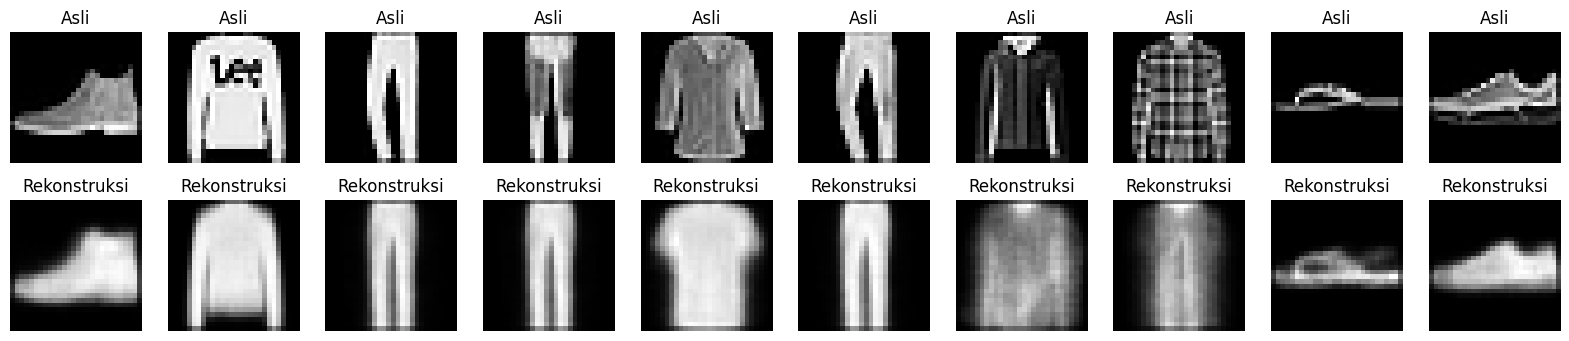

In [9]:
def plot_reconstruction(models, data, n=10):
    # Ambil data test
    x_test, y_test = data

    # Ambil gambar pertama dari data test
    test_images = x_test[:n]

    # Encode, lalu Decode (rekonstruksi)
    vae_model = models
    _, _, z = vae_model.encoder.predict(test_images)
    reconstructions = vae_model.decoder.predict(z)

    # Plot gambar asli vs. gambar hasil rekonstruksi
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Gambar Asli
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(test_images[i].squeeze(), cmap="gray")
        plt.title("Asli")
        ax.axis("off")

        # Gambar Rekonstruksi
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].squeeze(), cmap="gray")
        plt.title("Rekonstruksi")
        ax.axis("off")

    plt.show()

# Jalankan plotting
plot_reconstruction(vae, (x_test, y_test), n=10)

**Analisis Rekonstruksi:**
*   Jika VAE berfungsi dengan baik, gambar rekonstruksi harus sangat mirip dengan gambar aslinya, meskipun sedikit lebih buram karena model telah belajar mengabaikan detail yang tidak perlu (*smooth*) dan memaksanya untuk memampatkan data ke dalam $z$ (ruang laten).


### 6.2. Visualisasi Ruang Laten 2D

Karena kita memilih `LATENT_DIM = 2`, kita dapat memplot semua titik $z$ dari data uji dan mewarnainya berdasarkan label (kelas) aslinya.

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


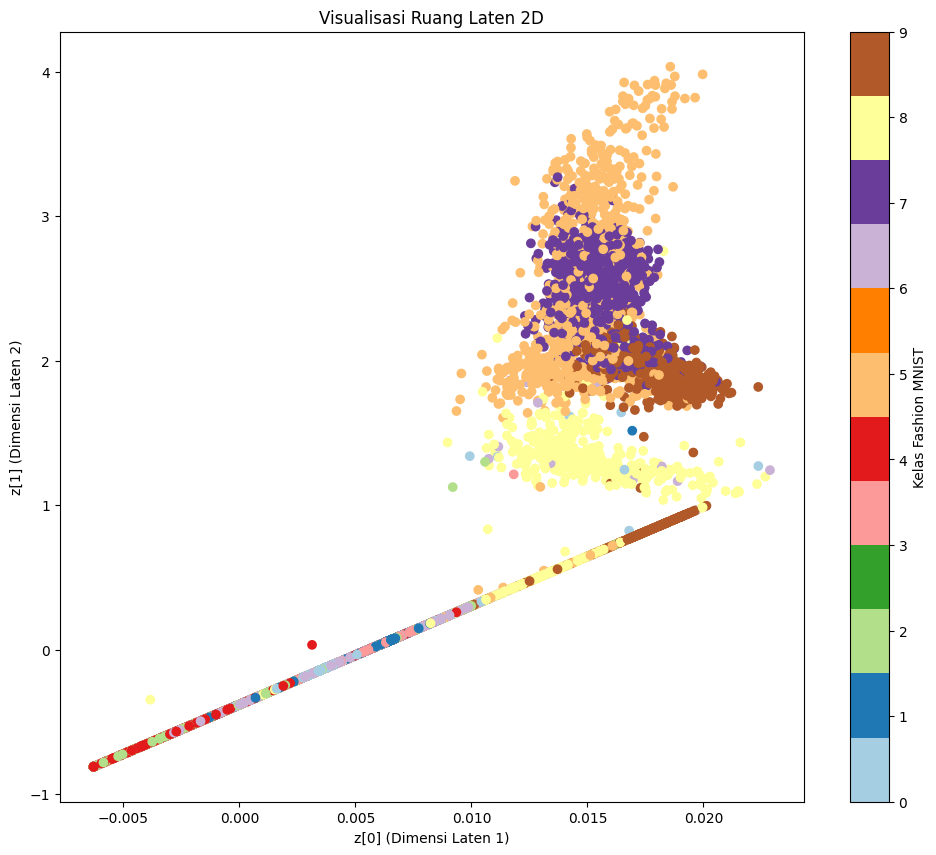

In [10]:
def plot_latent_space(encoder, x_test, y_test):
    # Prediksi mean (mu) untuk semua data test
    z_mean, _, _ = encoder.predict(x_test, batch_size=BATCH_SIZE)

    plt.figure(figsize=(12, 10))
    # Scatter plot mu_0 vs mu_1, diwarnai berdasarkan label y_test
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap="Paired")
    plt.colorbar(label='Kelas Fashion MNIST')
    plt.xlabel("z[0] (Dimensi Laten 1)")
    plt.ylabel("z[1] (Dimensi Laten 2)")
    plt.title("Visualisasi Ruang Laten 2D")
    plt.show()

# Jalankan plotting ruang laten
plot_latent_space(encoder, x_test, y_test)

**Analisis Ruang Laten:**
*   **Idealnya**, titik-titik dengan kelas yang sama (warna yang sama) harus mengelompok bersama.
*   Karena KL Divergence Loss, titik-titik harus terdistribusi secara *Gaussian* (bulat dan terpusat) di sekitar titik $(0,0)$. Hal ini sangat penting karena memungkinkan kita untuk mengambil sampel data baru secara seragam.

## 7. Penerapan: Generasi Data Baru

Ini adalah aplikasi inti dari VAE. Kita akan mengambil sampel dari distribusi prior (Distribusi Normal Standar) di ruang laten dan meminta Decoder untuk mengubahnya menjadi gambar.

### 7.1. Generasi dengan Sampling Acak


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


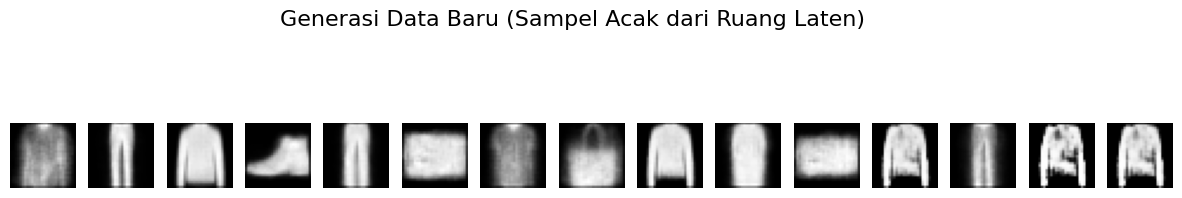

In [11]:
# Ambil sampel acak dari distribusi normal standar
n_samples = 15
random_latent_vectors = np.random.normal(size=(n_samples, LATENT_DIM))

# Dekode vektor acak menjadi gambar baru
generated_images = decoder.predict(random_latent_vectors)

# Plot hasilnya
plt.figure(figsize=(15, 3))
plt.suptitle("Generasi Data Baru (Sampel Acak dari Ruang Laten)", fontsize=16)
for i in range(n_samples):
    ax = plt.subplot(1, n_samples, i + 1)
    plt.imshow(generated_images[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.show()

### 7.2. Generasi dengan Manifold Latent (Interpolasi)

Dengan menanyakan Decoder pada grid titik di ruang laten, kita dapat melihat "manusia" (manifold) data yang dipelajari VAE. Transisi antar gambar yang halus menunjukkan bahwa ruang laten terstruktur dengan baik.


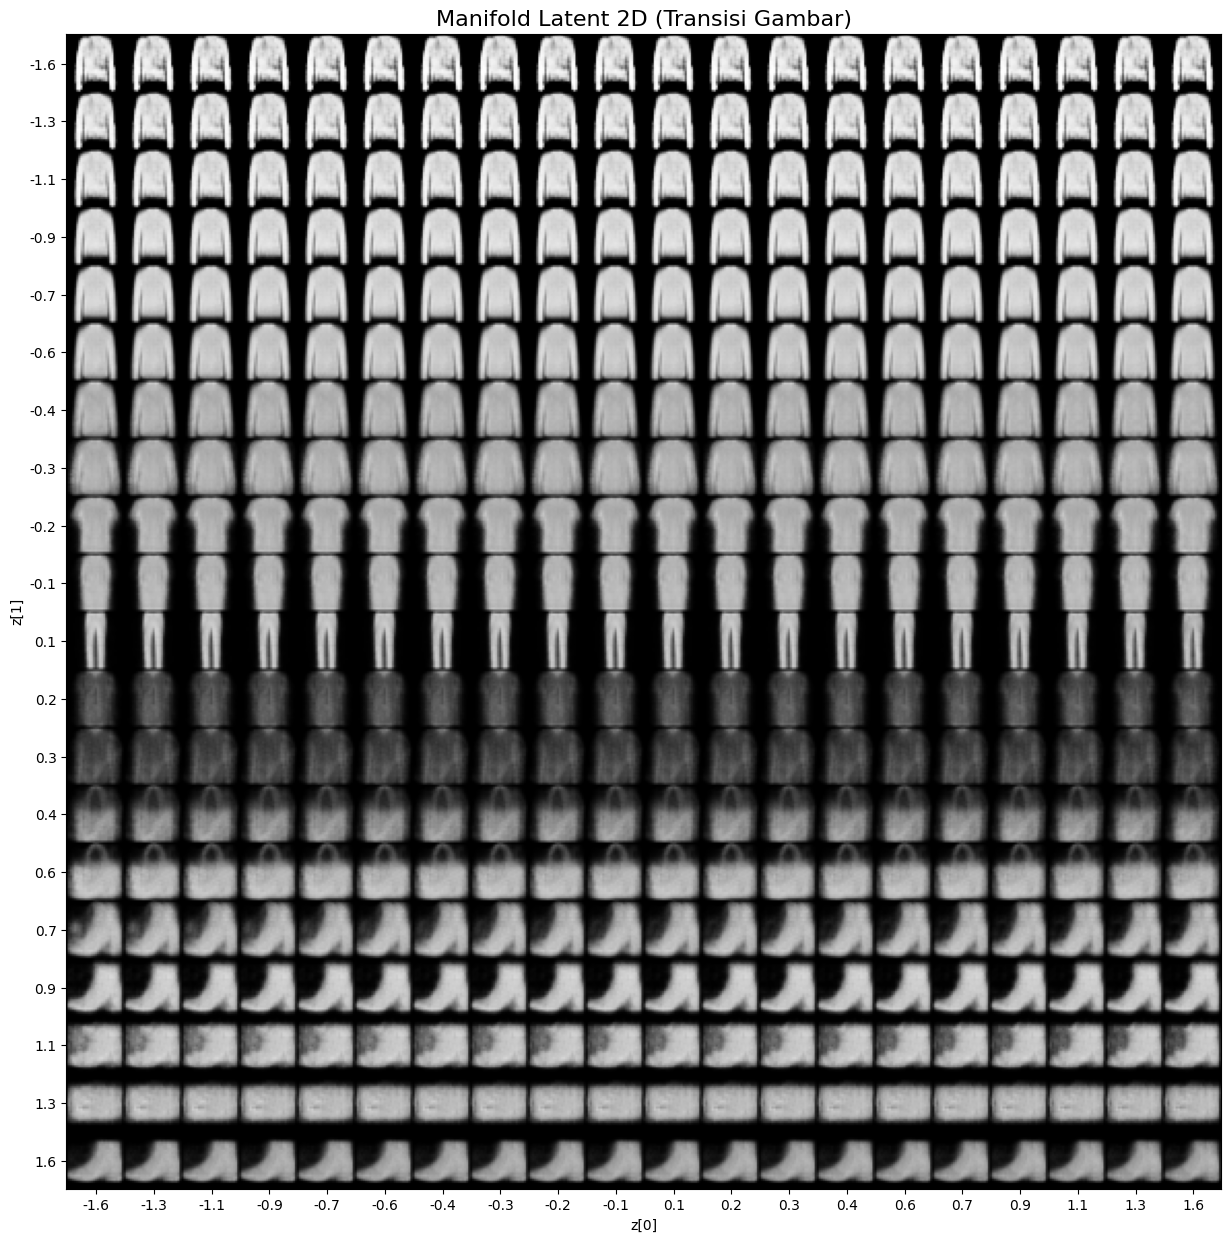

In [13]:
def plot_manifold(decoder, latent_dim):
    # Tentukan grid
    n = 20  # 20x20 gambar
    figure = np.zeros((IMG_WIDTH * n, IMG_HEIGHT * n))
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    # --- PERBAIKAN DARI SINI ---
    start_range = IMG_WIDTH // 2

    # Pastikan rentang berhenti tepat setelah n langkah (menghasilkan n titik)
    # n * IMG_WIDTH adalah panjang total pixel yang ditempati 20 gambar
    end_range = start_range + n * IMG_WIDTH

    pixel_range = np.arange(start_range, end_range, IMG_WIDTH) # Sekarang menghasilkan 20 titik
    # --- HINGGA SINI ---

    # Iterasi melalui grid dan dekode setiap titik
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            # Buat vektor laten 2D
            z_sample = np.array([[xi, yi]])

            # Dekode
            x_decoded = decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(IMG_WIDTH, IMG_HEIGHT)

            # Tempatkan pada figure besar
            figure[
                i * IMG_WIDTH : (i + 1) * IMG_WIDTH,
                j * IMG_HEIGHT : (j + 1) * IMG_HEIGHT,
            ] = digit

    # Plot figure
    plt.figure(figsize=(15, 15))

    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    # Jumlah pixel_range (20) sekarang sesuai dengan jumlah sample_range_x (20)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)

    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="gray")
    plt.title("Manifold Latent 2D (Transisi Gambar)", fontsize=16)
    plt.show()

# Jalankan plotting manifold (gunakan kode yang sudah diperbaiki)
plot_manifold(decoder, LATENT_DIM)

**Analisis Generasi Data:**
*   **Manifold Plot** menunjukkan bagaimana VAE mengatur jenis pakaian yang berbeda dalam ruang 2D. Perhatikan transisi yang halus antara T-shirt, celana, sepatu, dan tas tangan.
*   Setiap gambar pada grid ini adalah *data baru yang dihasilkan* oleh model, yang tidak ada dalam dataset pelatihan asli, membuktikan keberhasilan implementasi VAE sebagai model generatif.